In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pylab
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import datetime

import statsmodels.api as sm  
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [2]:
data = pd.read_csv('../data/siteA.csv')

In [3]:
print 'Creating a DateTime feature...by combining Date_Name & Purchase_Hour...'
data['Purchase_Hour'] = data['Purchase_Hour'].apply(lambda x: "{00}:00:00".format(x))
data['Date_Name'] = data['Date_Name'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
data['Date_Name'] = data['Date_Name'].apply(lambda x: datetime.datetime.strftime(x,'%Y-%m-%d'))
data['DateTime'] = pd.to_datetime(data['Date_Name'] + ' ' + data['Purchase_Hour'])
print data.info()

Creating a DateTime feature...by combining Date_Name & Purchase_Hour...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66160 entries, 0 to 66159
Data columns (total 5 columns):
Date_Name        66160 non-null object
subCategory      66160 non-null object
Purchase_Hour    66160 non-null object
sales            66160 non-null float64
DateTime         66160 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.5+ MB
None


In [5]:
data.set_index(['DateTime'], inplace=True)
print data.head()

                      Date_Name subCategory Purchase_Hour  sales
DateTime                                                        
2016-02-10 20:00:00  2016-02-10           A      20:00:00   8.34
2016-02-07 15:00:00  2016-02-07           A      15:00:00   5.84
2016-02-28 18:00:00  2016-02-28           A      18:00:00   7.38
2015-09-28 07:00:00  2015-09-28           A       7:00:00  12.30
2015-09-29 07:00:00  2015-09-29           A       7:00:00  24.03


In [ ]:
# Plot sales vs. DateTime for each subcategory...
for cat in data['subCategory'].unique():
    data_cat = data[data['subCategory'] == cat]
    data_cat = data_cat.drop(['Date_Name', 'subCategory', 'Purchase_Hour', ], axis=1)
    x = np.array(data_cat.index)
    y = np.array(data.sales)
    print x.shape, y.shape
#     plt.plot(x, y, 'o')

    
    #     , title='Category {} Sales'.format(cat)

KeyboardInterrupt: 

In [7]:
# Make a dataframe for each category, and put it into a list...len(list) = 16
# Essentially becomes a list of dataframe
def make_dataframe(df, lis):
    f = lambda x: df[df['subCategory'] == x]
    return map(f, lis)

temp_list = data['subCategory'].unique()
splitted_data = make_dataframe(data, temp_list)
print len(splitted_data)
print splitted_data[2][0:5]

16
                      Date_Name subCategory Purchase_Hour   sales
DateTime                                                         
2016-03-01 07:00:00  2016-03-01           C       7:00:00  460.34
2016-03-04 07:00:00  2016-03-04           C       7:00:00  414.03
2016-03-07 07:00:00  2016-03-07           C       7:00:00  370.37
2016-03-08 07:00:00  2016-03-08           C       7:00:00  368.68
2016-03-11 07:00:00  2016-03-11           C       7:00:00  439.15


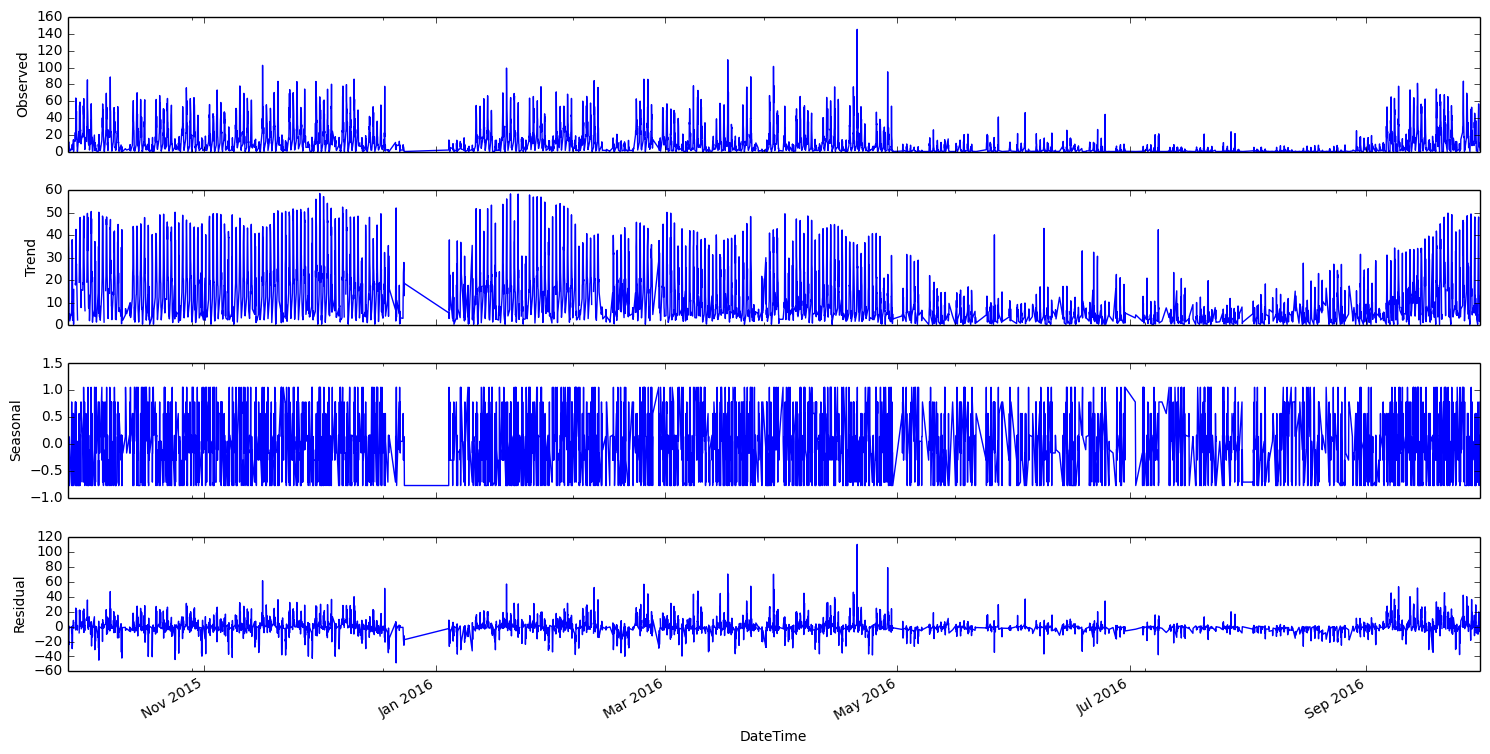

In [8]:
# Category A, seasonal decomposition plots...
decomposition = seasonal_decompose(splitted_data[0]['sales'], freq=12)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [11]:
# A function to test serie's stationarity... 
def test_stationarity(timeseries, category):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('{} - Rolling Mean & Standard Deviation'.format(category))
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


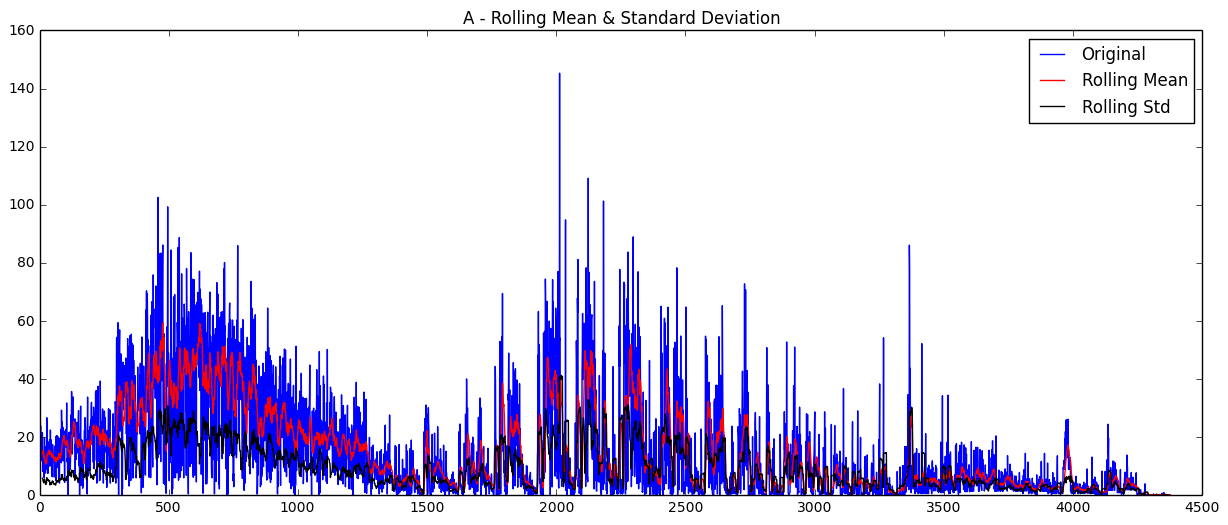

Results of Dickey-Fuller Test:
Test Statistic                   -3.798716
p-value                           0.002920
#Lags Used                       29.000000
Number of Observations Used    4347.000000
Critical Value (5%)              -2.862205
Critical Value (1%)              -3.431855
Critical Value (10%)             -2.567124
dtype: float64


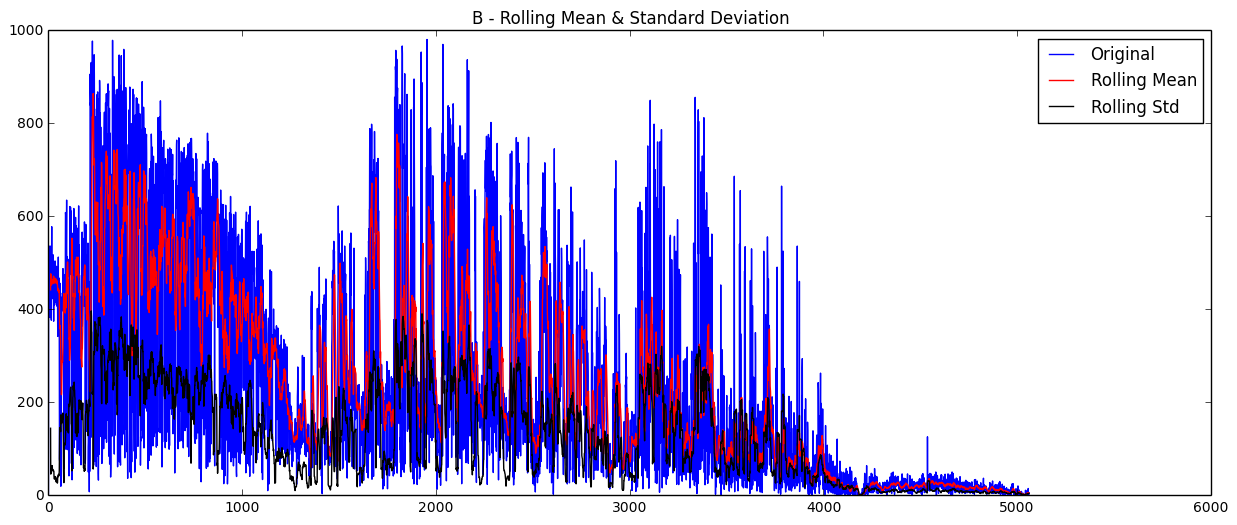

Results of Dickey-Fuller Test:
Test Statistic                   -4.094591
p-value                           0.000989
#Lags Used                       30.000000
Number of Observations Used    5031.000000
Critical Value (5%)              -2.862115
Critical Value (1%)              -3.431650
Critical Value (10%)             -2.567076
dtype: float64


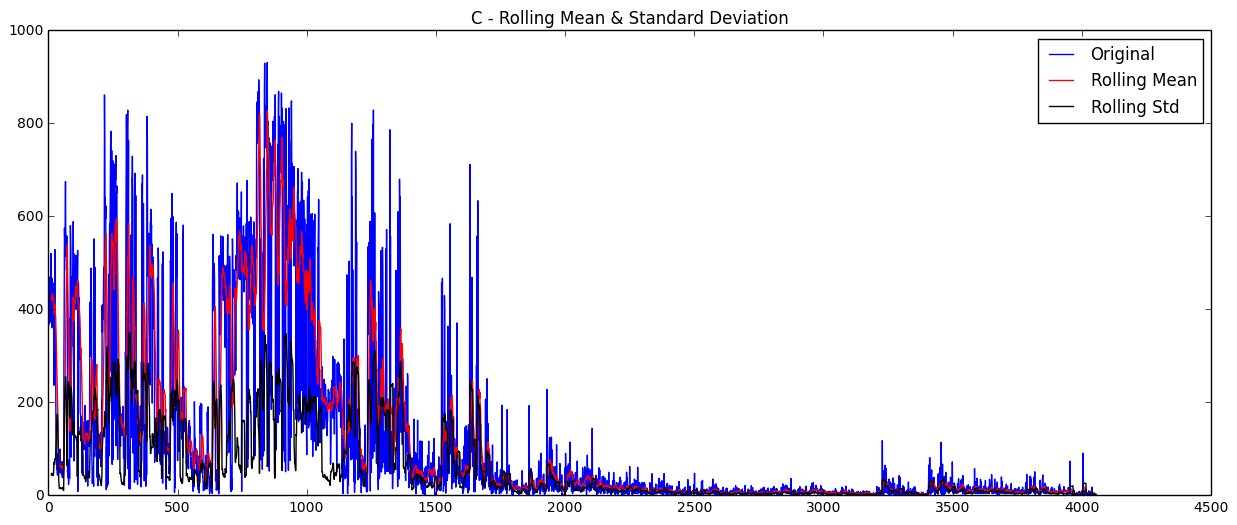

Results of Dickey-Fuller Test:
Test Statistic                   -3.111610
p-value                           0.025706
#Lags Used                       31.000000
Number of Observations Used    4025.000000
Critical Value (5%)              -2.862258
Critical Value (1%)              -3.431976
Critical Value (10%)             -2.567152
dtype: float64


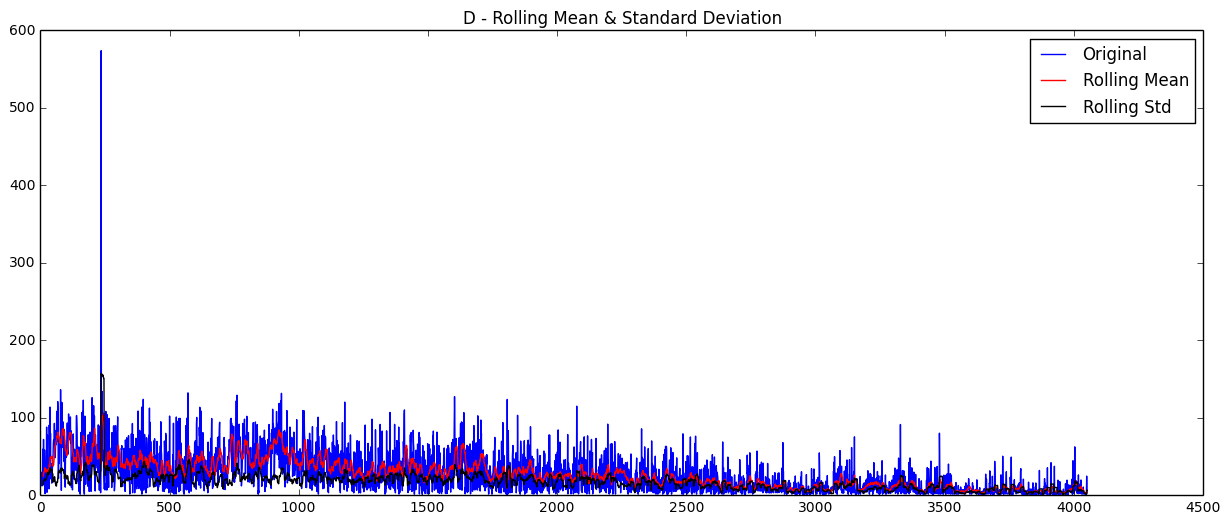

Results of Dickey-Fuller Test:
Test Statistic                   -2.991698
p-value                           0.035677
#Lags Used                       29.000000
Number of Observations Used    4023.000000
Critical Value (5%)              -2.862259
Critical Value (1%)              -3.431977
Critical Value (10%)             -2.567153
dtype: float64


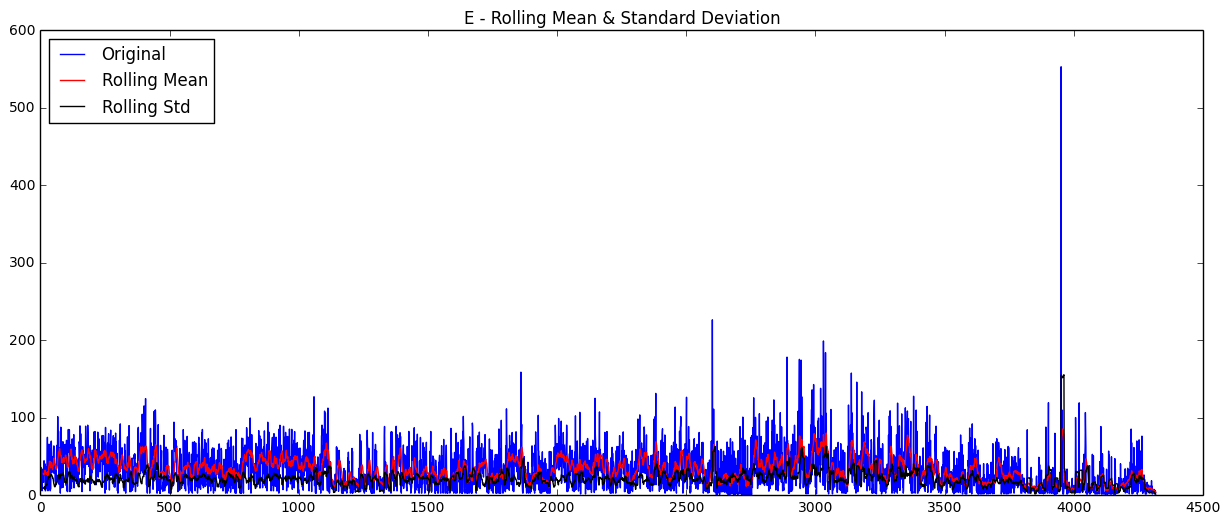

Results of Dickey-Fuller Test:
Test Statistic                -1.282654e+01
p-value                        5.997194e-24
#Lags Used                     1.000000e+01
Number of Observations Used    4.307000e+03
Critical Value (5%)           -2.862211e+00
Critical Value (1%)           -3.431869e+00
Critical Value (10%)          -2.567127e+00
dtype: float64


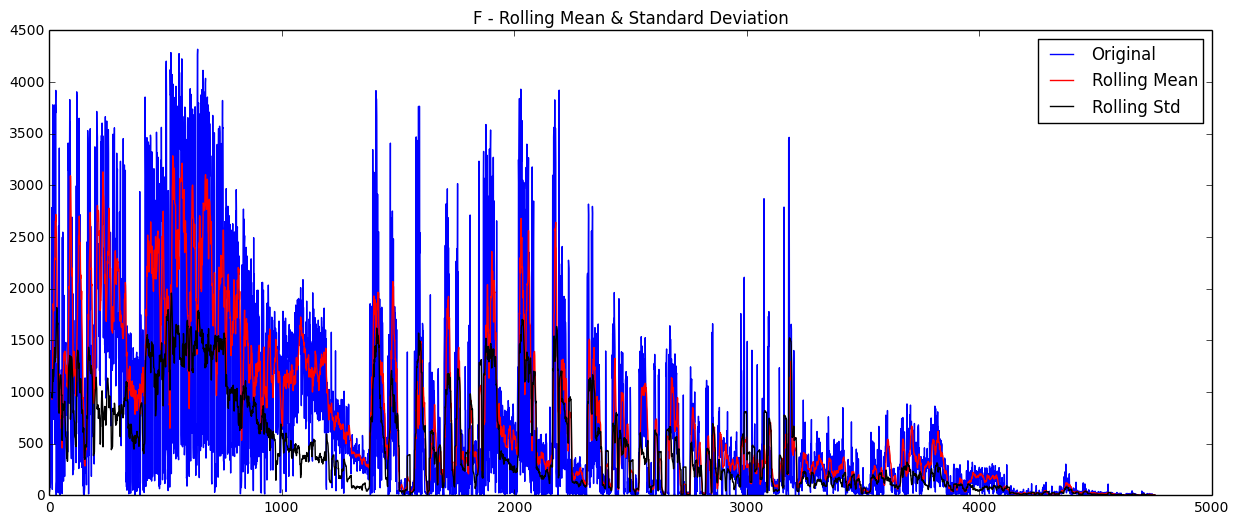

Results of Dickey-Fuller Test:
Test Statistic                   -4.235988
p-value                           0.000572
#Lags Used                       30.000000
Number of Observations Used    4725.000000
Critical Value (5%)              -2.862152
Critical Value (1%)              -3.431735
Critical Value (10%)             -2.567096
dtype: float64


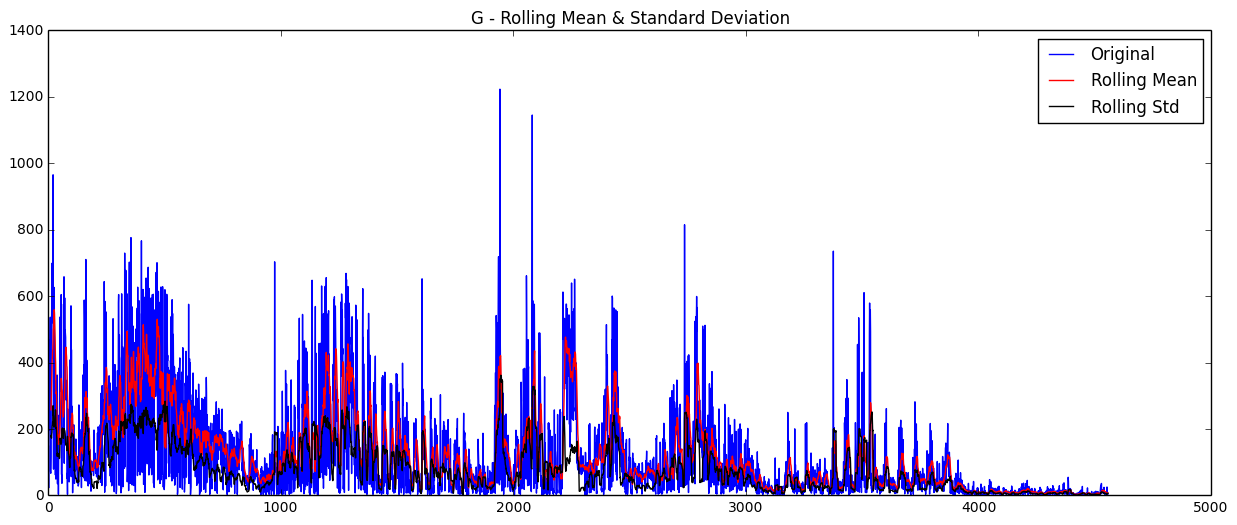

Results of Dickey-Fuller Test:
Test Statistic                   -5.000485
p-value                           0.000022
#Lags Used                       29.000000
Number of Observations Used    4528.000000
Critical Value (5%)              -2.862179
Critical Value (1%)              -3.431795
Critical Value (10%)             -2.567110
dtype: float64


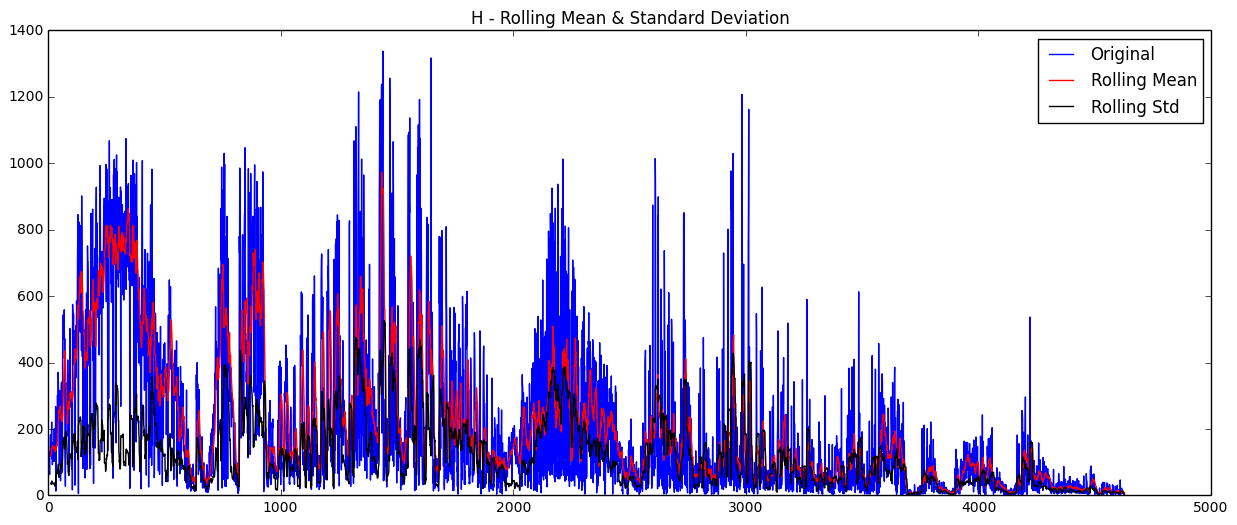

Results of Dickey-Fuller Test:
Test Statistic                   -4.150558
p-value                           0.000798
#Lags Used                       31.000000
Number of Observations Used    4597.000000
Critical Value (5%)              -2.862169
Critical Value (1%)              -3.431773
Critical Value (10%)             -2.567105
dtype: float64


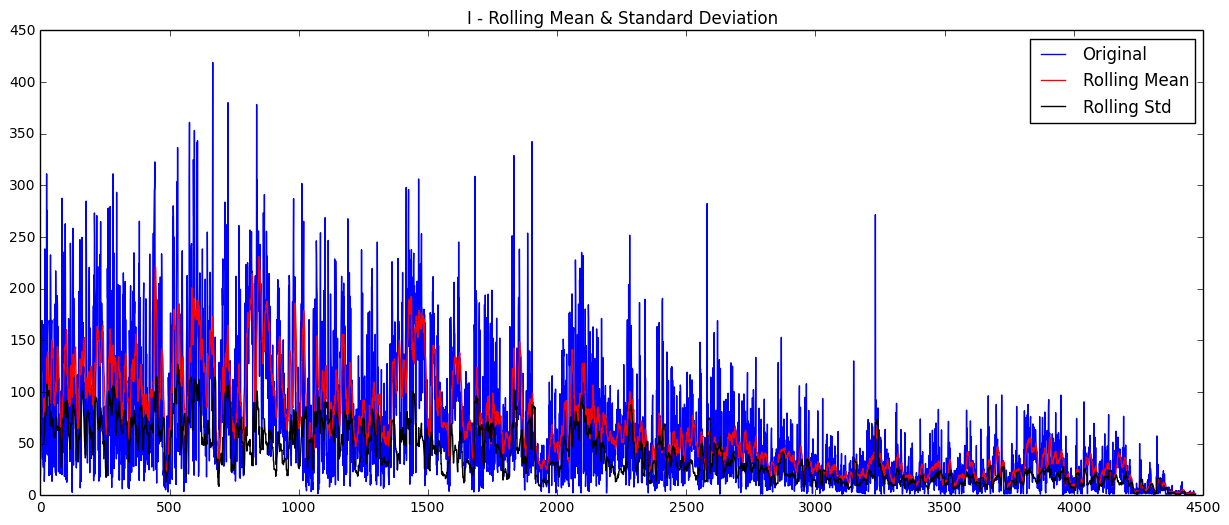

Results of Dickey-Fuller Test:
Test Statistic                   -3.994782
p-value                           0.001438
#Lags Used                       32.000000
Number of Observations Used    4439.000000
Critical Value (5%)              -2.862191
Critical Value (1%)              -3.431824
Critical Value (10%)             -2.567117
dtype: float64


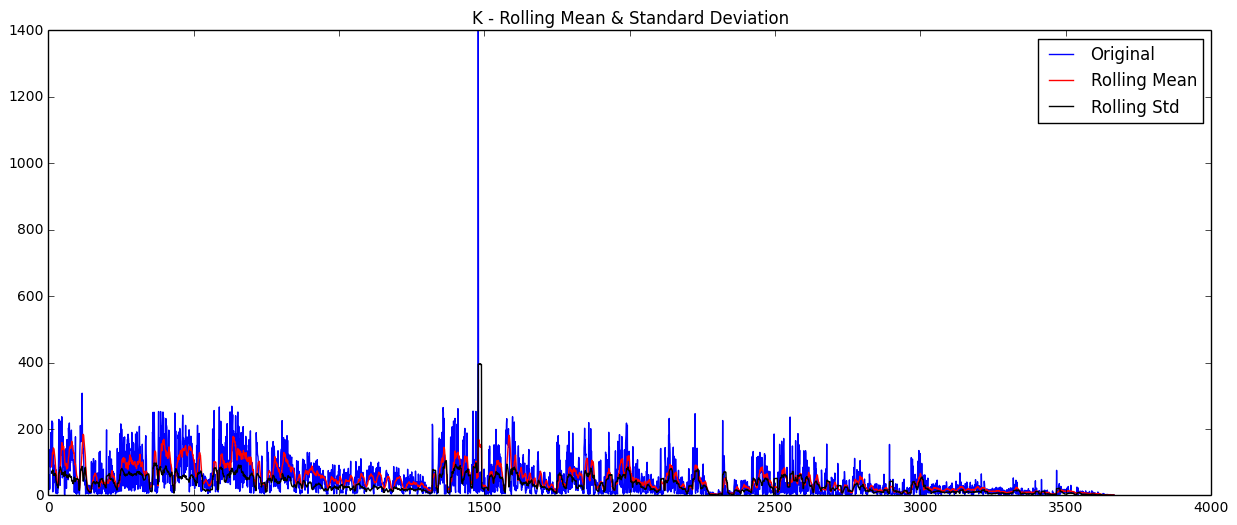

Results of Dickey-Fuller Test:
Test Statistic                   -5.011522
p-value                           0.000021
#Lags Used                       29.000000
Number of Observations Used    3637.000000
Critical Value (5%)              -2.862335
Critical Value (1%)              -3.432149
Critical Value (10%)             -2.567193
dtype: float64


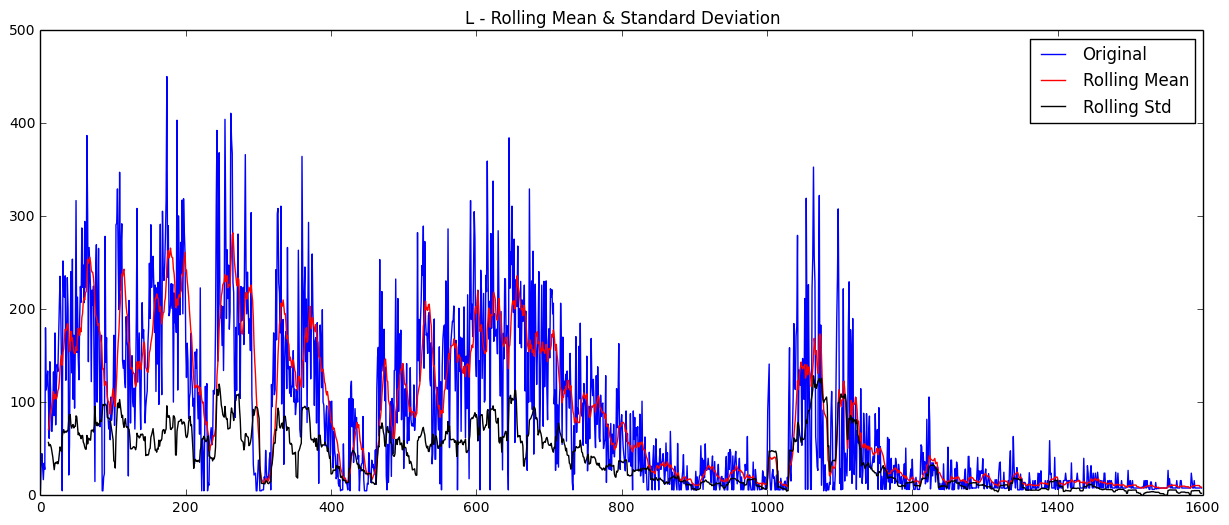

Results of Dickey-Fuller Test:
Test Statistic                   -3.426334
p-value                           0.010093
#Lags Used                       16.000000
Number of Observations Used    1582.000000
Critical Value (5%)              -2.863369
Critical Value (1%)              -3.434490
Critical Value (10%)             -2.567744
dtype: float64


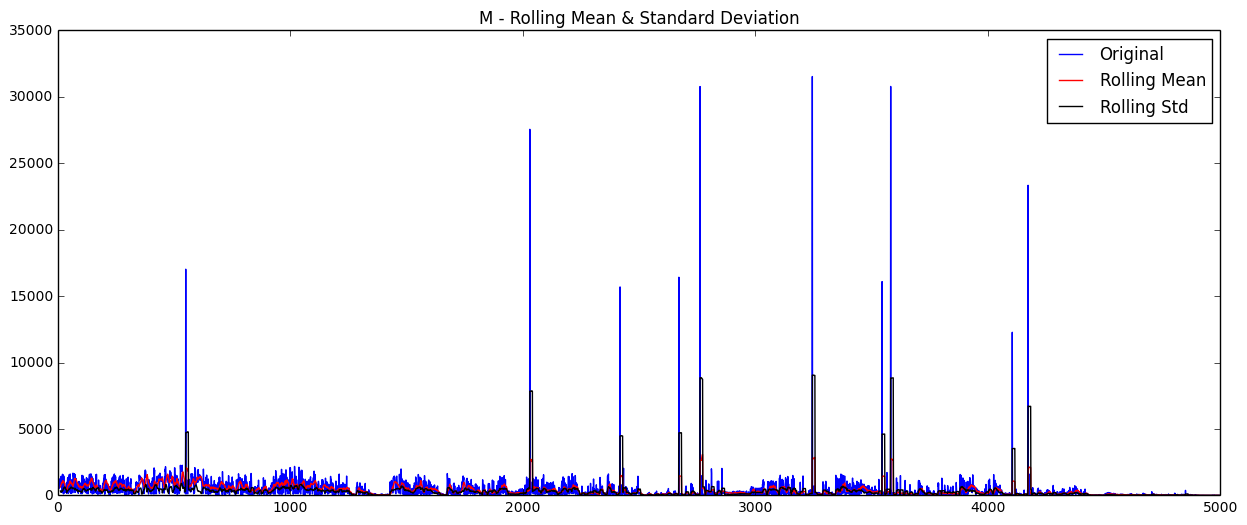

Results of Dickey-Fuller Test:
Test Statistic                -9.271824e+00
p-value                        1.320532e-15
#Lags Used                     2.500000e+01
Number of Observations Used    4.970000e+03
Critical Value (5%)           -2.862122e+00
Critical Value (1%)           -3.431666e+00
Critical Value (10%)          -2.567080e+00
dtype: float64


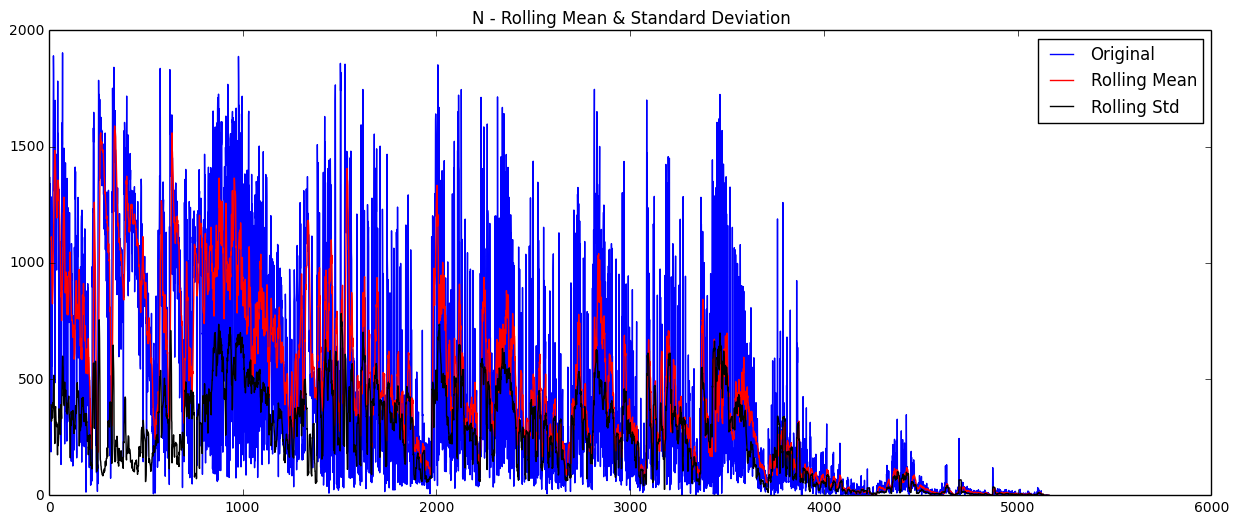

Results of Dickey-Fuller Test:
Test Statistic                   -4.038663
p-value                           0.001221
#Lags Used                       30.000000
Number of Observations Used    5131.000000
Critical Value (5%)              -2.862103
Critical Value (1%)              -3.431625
Critical Value (10%)             -2.567070
dtype: float64


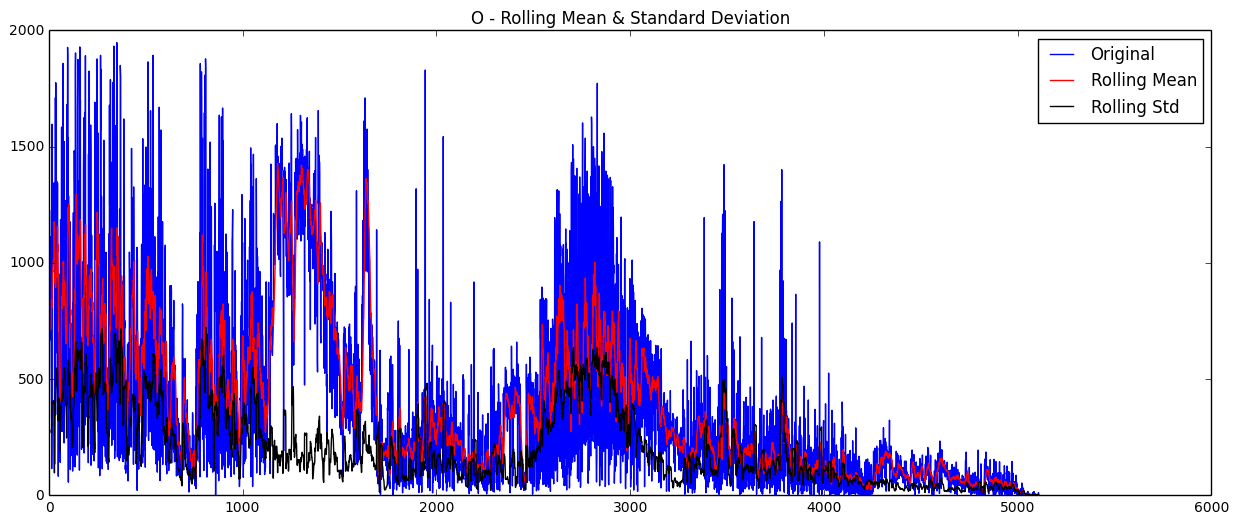

Results of Dickey-Fuller Test:
Test Statistic                   -3.512973
p-value                           0.007660
#Lags Used                       32.000000
Number of Observations Used    5076.000000
Critical Value (5%)              -2.862110
Critical Value (1%)              -3.431639
Critical Value (10%)             -2.567073
dtype: float64


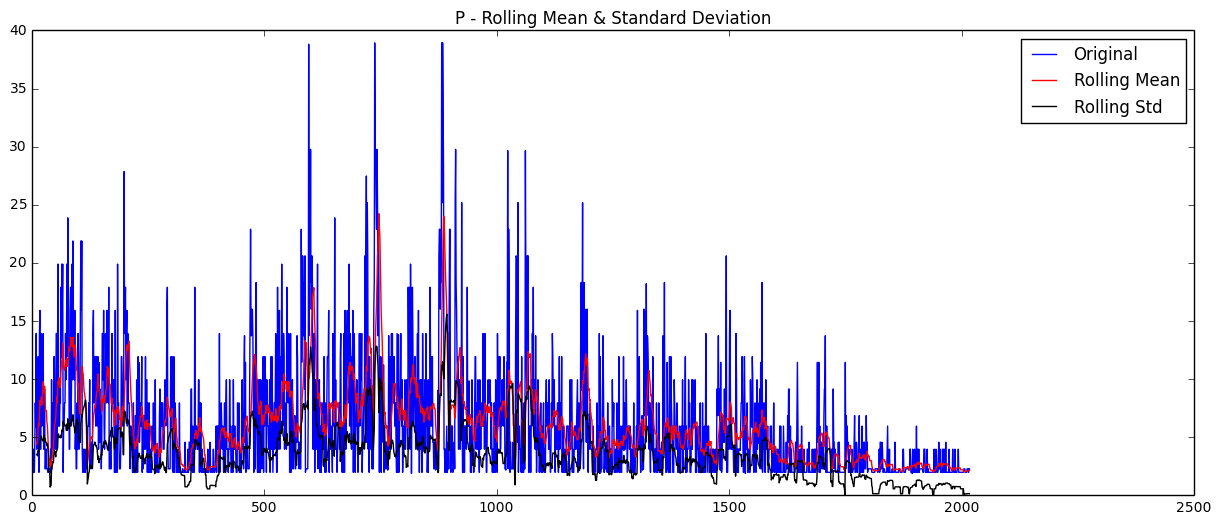

Results of Dickey-Fuller Test:
Test Statistic                   -4.696967
p-value                           0.000085
#Lags Used                       26.000000
Number of Observations Used    1991.000000
Critical Value (5%)              -2.862993
Critical Value (1%)              -3.433639
Critical Value (10%)             -2.567543
dtype: float64


In [16]:
# Plot and test for rolling statistics, and Dickey-Fuller test.
# The null hypothesis is that the TS is 'non-stationary'.
    # If the ‘Test Statistic’ is less than the ‘Critical Value’, 
    # we can reject the null hypothesis and say that the series is stationary.
for i in range(0,15):
    test_stationarity(splitted_data[i]['sales'], splitted_data[i].iloc[0]['subCategory'])

###### Non-stationary: Category E
###### All other categories are 95% confident stationary

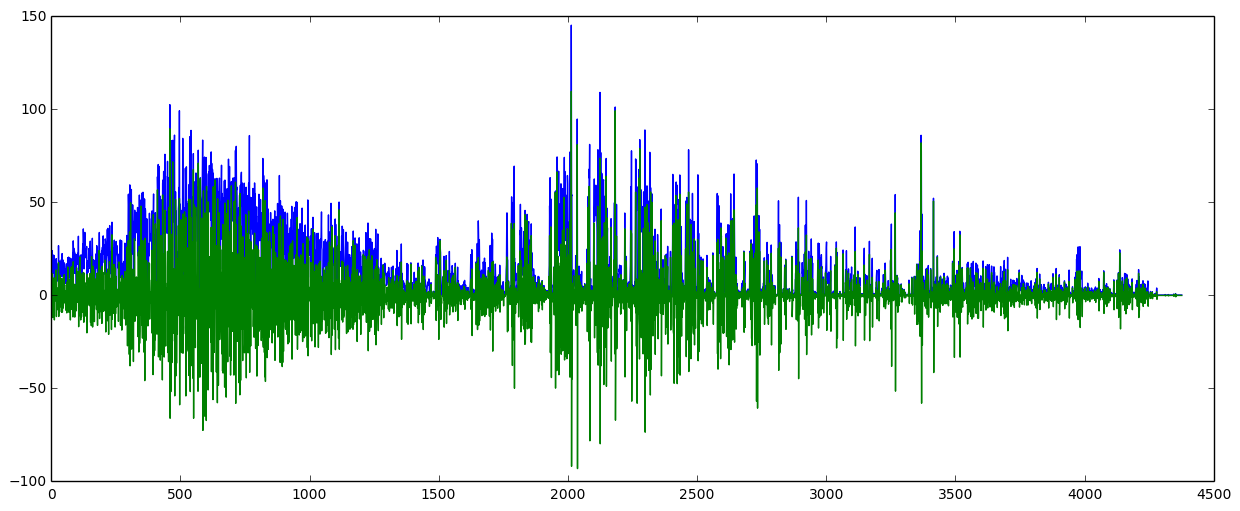

In [24]:
# Differencing to deal with trend & seasonality...
splitted_data_diff = splitted_data[0]['sales'] - splitted_data[0]['sales'].shift()
plt.plot(splitted_data[0]['sales'])
# plt.plot(splitted_data[0]['sales'].shift())
plt.plot(splitted_data_diff)

In [28]:
# Drop NA values, otherwise Dickey-Fuller Test would fail...
print splitted_data_diff.isnull().values.sum()
splitted_data_diff.dropna(inplace=True)
print splitted_data_diff.isnull().values.sum()

1
0


/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


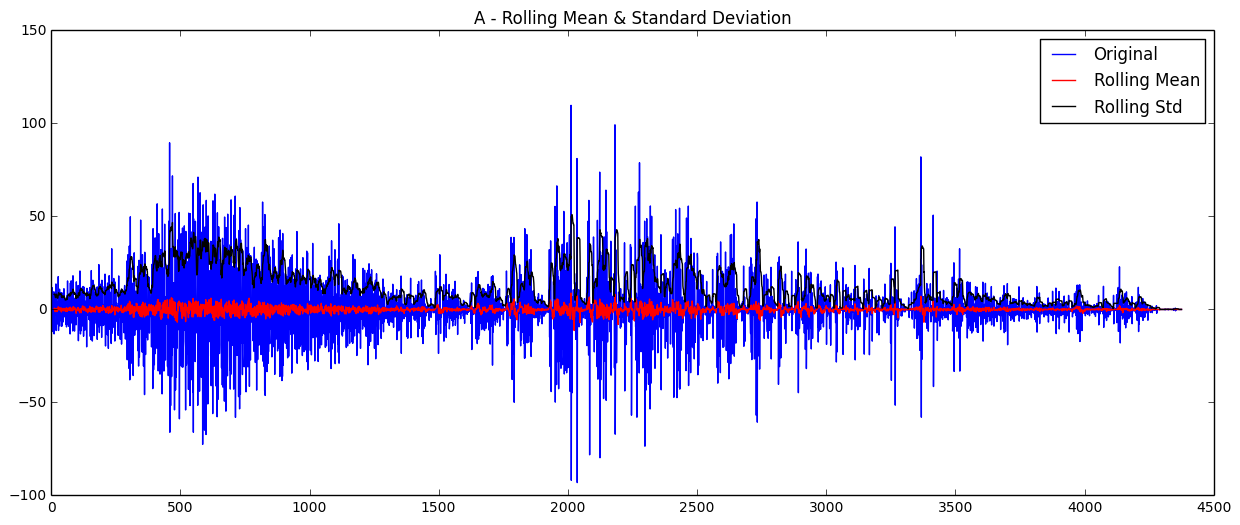

Results of Dickey-Fuller Test:
Test Statistic                  -19.459779
p-value                           0.000000
#Lags Used                       28.000000
Number of Observations Used    4347.000000
Critical Value (5%)              -2.862205
Critical Value (1%)              -3.431855
Critical Value (10%)             -2.567124
dtype: float64


In [29]:
test_stationarity(splitted_data_diff, 'A')

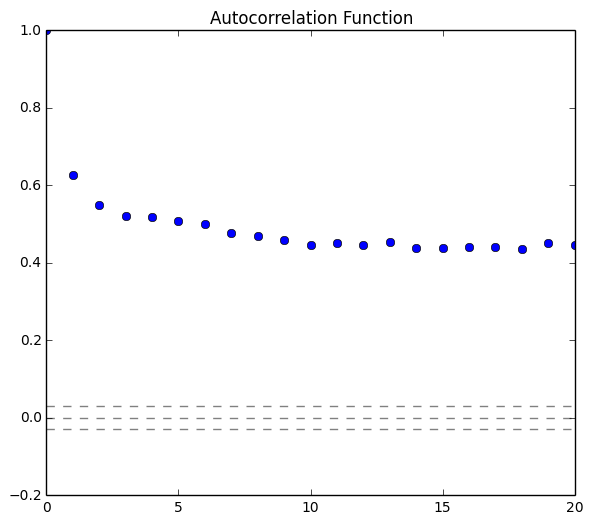

In [72]:
# ACF: Autocorrelation Function
lag_acf = acf(splitted_data[0]['sales'], nlags=20)
plt.subplot(121) 
plt.plot(lag_acf, 'o')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(splitted_data[0]['sales'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(splitted_data[0]['sales'])), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

###### ACF tails off...never reaches 0...
###### Category A is probably AR(p), p being cut off from PACF

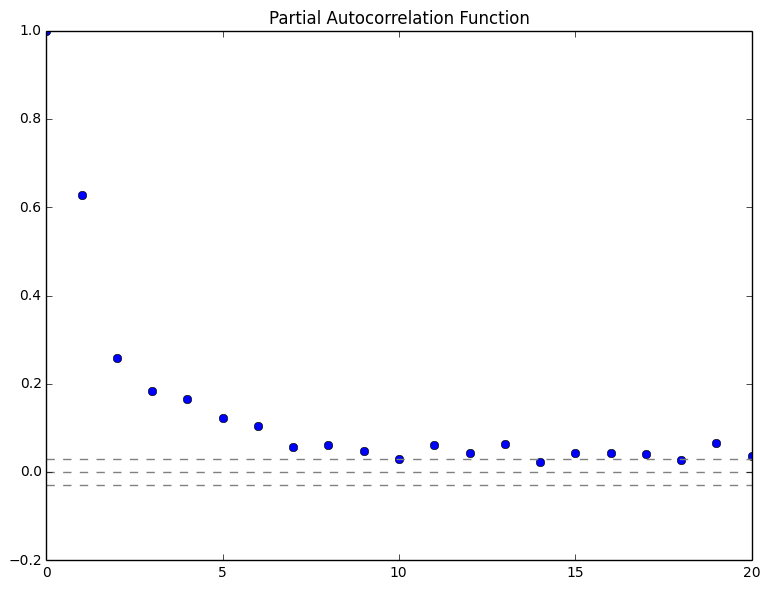

In [73]:
# PACF: Partial Autocorrelation Function
lag_pacf = pacf(splitted_data[0]['sales'], nlags=20, method='ols')
plt.subplot(122)
plt.plot(lag_pacf, 'o')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(splitted_data[0]['sales'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(splitted_data[0]['sales'])), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

###### PACF cuts off after lag 2...category A is probably AR(2) or AR(3)

In [ ]:
# p=1 (827,222) ; p=2 (771,855); p=3 (745,533); p=4 (725,114); p=5 (714,337)

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                 4377
Model:                     ARMA(3, 0)   Log Likelihood              -17454.939
Method:                       css-mle   S.D. of innovations             13.051
Date:                Wed, 15 Feb 2017   AIC                          34919.878
Time:                        01:36:03   BIC                          34951.799
Sample:                    02-10-2016   HQIC                         34931.142
                         - 10-05-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.7843      0.873     16.931      0.000      13.073      16.496
ar.L1.sales     0.4170      0.015     28.073      0.000       0.388       0.446
ar.L2.sales     0.1729      0.016     10.858    

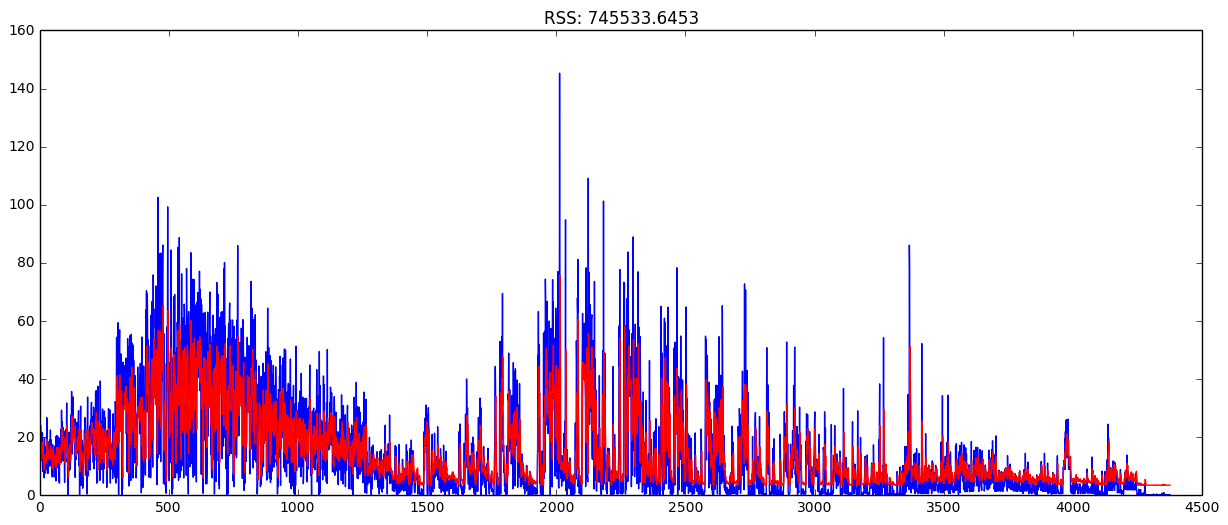

In [92]:
# AR model.
model = ARIMA(splitted_data[0]['sales'], order=(3, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(splitted_data[0]['sales'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - splitted_data[0]['sales'])**2))
print results_AR.summary()

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                 4377
Model:                     ARMA(0, 2)   Log Likelihood              -17886.308
Method:                       css-mle   S.D. of innovations             14.403
Date:                Wed, 15 Feb 2017   AIC                          35780.615
Time:                        01:36:48   BIC                          35806.152
Sample:                    02-10-2016   HQIC                         35789.626
                         - 10-05-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.8107      0.386     38.384      0.000      14.054      15.567
ma.L1.sales     0.4853      0.015     32.455      0.000       0.456       0.515
ma.L2.sales     0.2873      0.013     22.669    

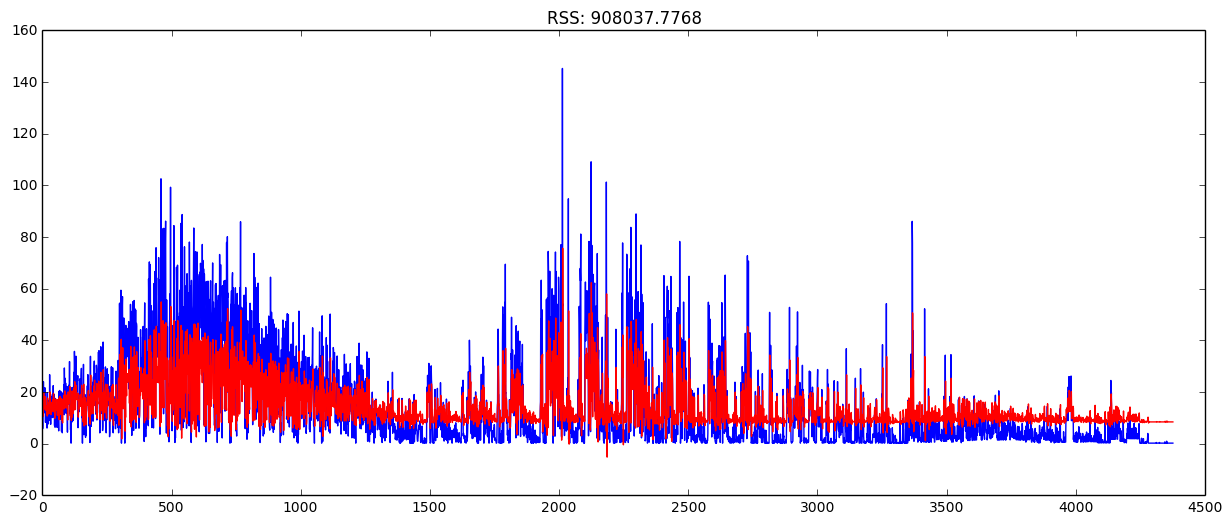

In [93]:
# MA model.
model = ARIMA(splitted_data[0]['sales'], order=(0, 0, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(splitted_data[0]['sales'])
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - splitted_data[0]['sales'])**2))
print results_MA.summary()

/Library/Python/2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


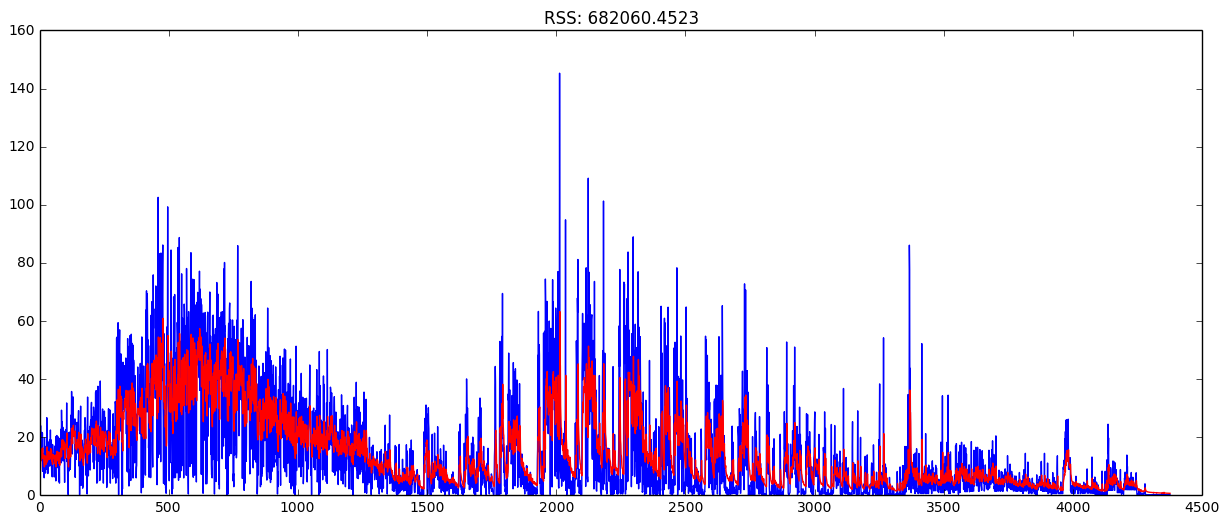

In [86]:
# Combined model.
model = ARIMA(splitted_data[0]['sales'], order=(3, 0, 2))
results_ARIMA = model.fit(disp=-1)  
plt.plot(splitted_data[0]['sales'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - splitted_data[0]['sales'])**2))

In [64]:
data = data.drop(['Purchase_Hour'], axis=1)
print data.columns
# print data[data['subCategory'] == 'A'].plot.scatter(x = 'index', y = 'sales')

Index([u'subCategory', u'sales'], dtype='object')


In [66]:
data = data[data['subCategory'] == 'A']
data = data.drop(['subCategory'], axis=1)
print data.shape

(4377, 1)


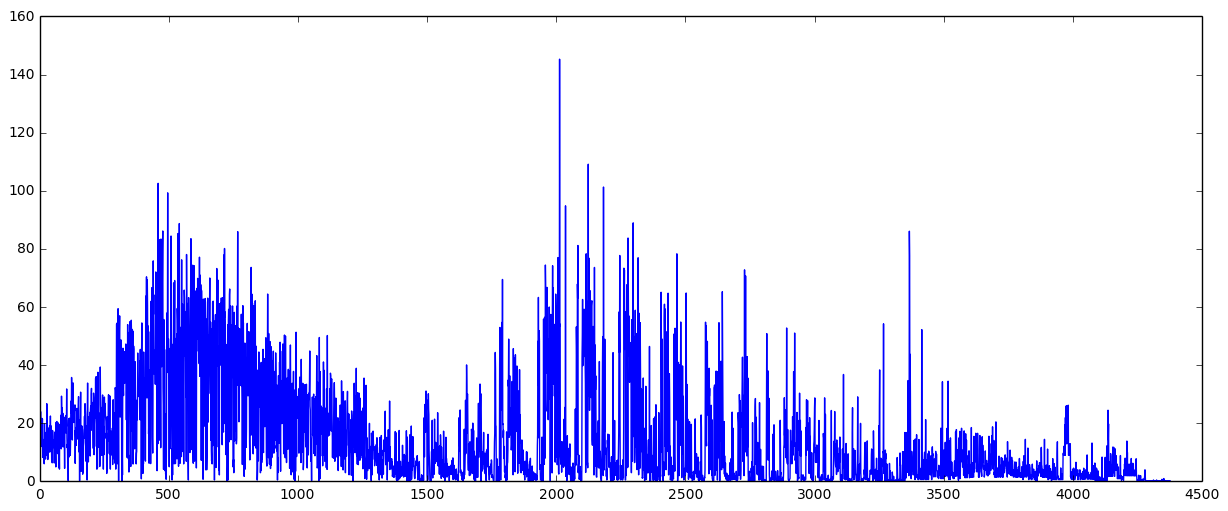

In [67]:
plt.plot(data)

In [72]:
print data.shape
print data['sales'].unique().shape

(4377, 1)
(2116,)


In [ ]:
# Graph all categories on 1 scatter plot...too messy...
data_dropped = data.drop(['Date_Name', 'Purchase_Hour'], axis=1)
groups = data_dropped.groupby('subCategory')

fig, ax = plt.subplots()
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.index, group.sales, marker='o', linestyle='', ms=12, label=name)
ax.legend()
ax.set_ylim([0, 5000])

In [4]:
print site_A.info()
# print '\n', site_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66160 entries, 0 to 66159
Data columns (total 4 columns):
Date_Name        66160 non-null object
subCategory      66160 non-null object
Purchase_Hour    66160 non-null int64
sales            66160 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.0+ MB
None
